<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Введение" data-toc-modified-id="Введение-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Введение</a></span></li><li><span><a href="#Цель" data-toc-modified-id="Цель-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Цель</a></span></li><li><span><a href="#Импорты" data-toc-modified-id="Импорты-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Импорты</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Загрузка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделим-данные-на-train-и-test" data-toc-modified-id="Разделим-данные-на-train-и-test-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделим данные на train и test</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Анализ-результатов-обучения" data-toc-modified-id="Анализ-результатов-обучения-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Анализ результатов обучения</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#CatBoostRegressor-на-тестовых-данных" data-toc-modified-id="CatBoostRegressor-на-тестовых-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CatBoostRegressor на тестовых данных</a></span></li><li><span><a href="#LGBMRegressor-на-тестовых-данных" data-toc-modified-id="LGBMRegressor-на-тестовых-данных-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LGBMRegressor на тестовых данных</a></span></li><li><span><a href="#Анализ-результатов-тестирования" data-toc-modified-id="Анализ-результатов-тестирования-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Анализ результатов тестирования</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

### Введение

Собраны исторические данные о зсказах такси в аэропортах. <br>
Для превлечения водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

### Цель

Построить модель предсказания заказов на следующий час с значением RMSE меньше 48

### Импорты

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

RND = 123
SIZE = (12, 3)

### Загрузка данных

In [2]:
try:
    df = pd.read_csv('taxi.csv',  index_col='datetime', parse_dates=['datetime'])
except: 
    df = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=['datetime'])
df.sort_index(inplace=True)

Проверка порядка рассположения индексов

In [3]:
df.index.is_monotonic

True

Посмотрим, на данные

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

<AxesSubplot:xlabel='datetime'>

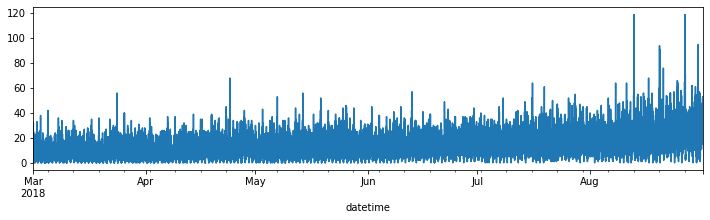

In [6]:
df.plot(legend=False, figsize=SIZE, ax=plt.gca())

* Данные по заказам идут с интервалом в 10 мин
* Пропуски отсутствуют

Необходимо выполнить ресемплирование по одному часу.

In [7]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

<AxesSubplot:xlabel='datetime'>

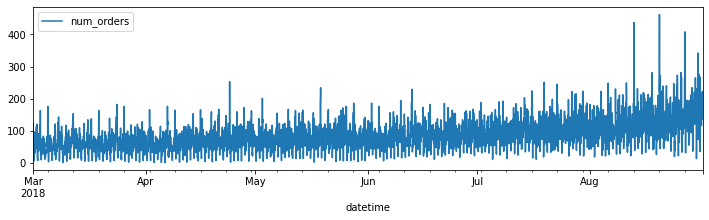

In [8]:
df.plot(figsize=SIZE, ax=plt.gca())

**Проведем декомпресиию данных и рассмотрим тренд, сезонность и остаток**

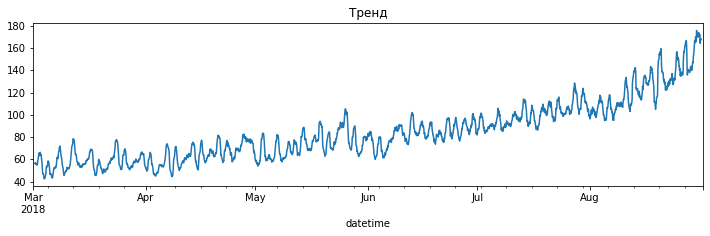

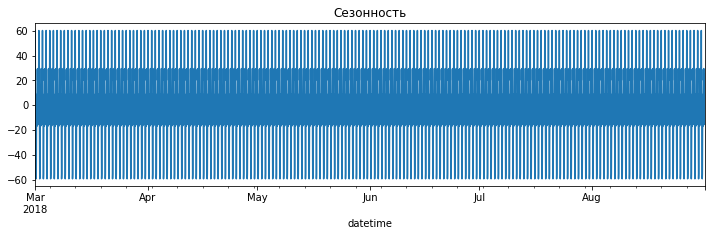

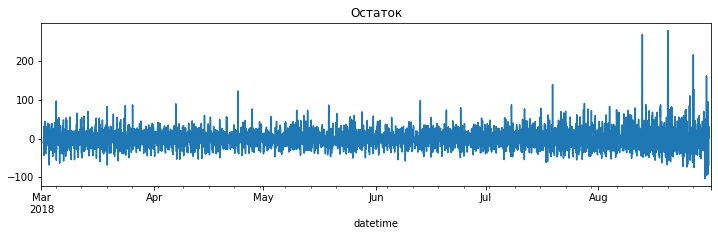

In [9]:
decomposed_data = seasonal_decompose(df)

decomposed_data.trend.plot(figsize=SIZE)
plt.title('Тренд')
plt.show()

decomposed_data.seasonal.plot(figsize=SIZE)
plt.title('Сезонность')
plt.show()
 
decomposed_data.resid.plot(figsize=SIZE)
plt.title('Остаток')
plt.show()

Рассмотрим более короткий период - половину последнего месяца наблюдений. <br>
*(а, то какля-маля получилось)*

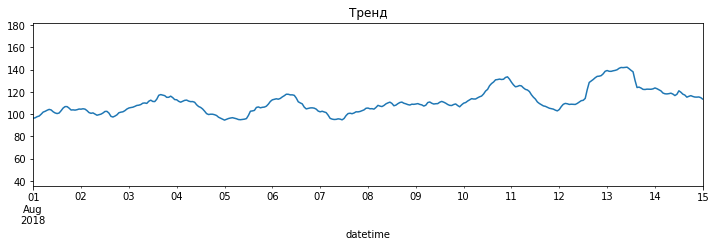

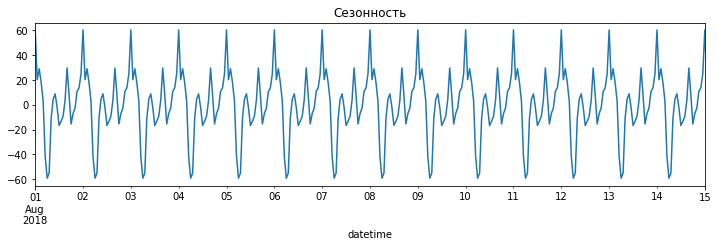

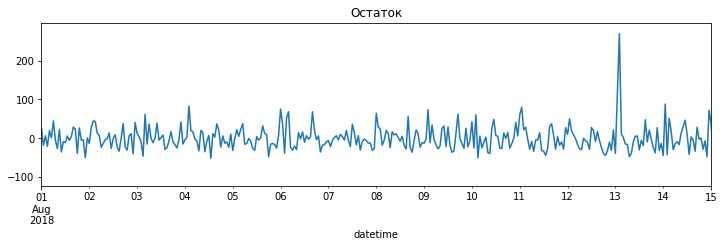

In [10]:
period = ['2018-08-01','2018-08-15']
decomposed_data.trend.plot(figsize=SIZE, xlim=(period))
plt.title('Тренд')
plt.show()
decomposed_data.seasonal.plot(figsize=SIZE, xlim=(period))
plt.title('Сезонность')
plt.show()
decomposed_data.resid.plot(figsize=SIZE, xlim=(period))
plt.title('Остаток')
plt.show()

* <b>ряд не стационарный. Тренд меняется со временем и не имеет значительных падений
* <b>прослеживается внутрисуточная сезонность
* <b>по месячная сезонность не наблюдается

По видимому больше людей пользуются услугами такси. Тут можно говорить о тенеденции к увеличению спроса и росте компании.

Данные представляют собой не стационарный ряд. Его свойства быстро меняются, что вызывает трудности при анализе.<br>
Ряд следует привести к стационарному, и добавить признаки:
* месяц
* день месяца
* день недели
* час

## Обучение

**Создадим новые признаки и удалим пустые значения**

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [12]:
df = make_features(df, 2, 24) 

In [13]:
df = df.dropna()

### Разделим данные на train и test

<AxesSubplot:title={'center':'Разделение датафрейма'}, ylabel='data'>

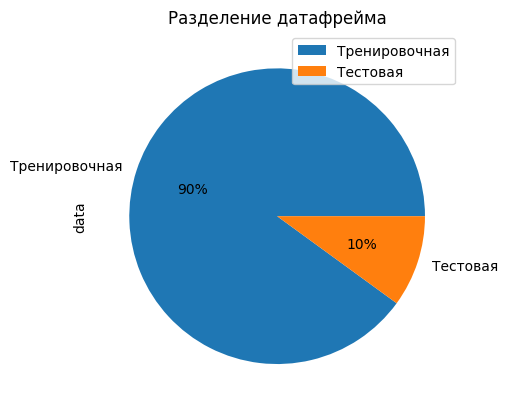

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('num_orders', axis=1), df.num_orders, shuffle=False, test_size=0.1, random_state=RND)
data_separation = pd.DataFrame({'name': ['Тренировочная',
                                         'Тестовая'],
                                'data': [
                                    X_train.shape[0],
                                    X_test.shape[0]]})
data_separation = data_separation.set_index('name')
data_separation.plot(kind='pie', y='data', autopct='%1.0f%%', title='Разделение датафрейма')

### LinearRegression

In [15]:
# тут для итоговой таблицы
name_model = []
time_model = []
RMSE_model = []

In [16]:
%time
name_model.append('LinearRegression')
start = time.time()

lr_model = LinearRegression()

rmse = abs(cross_val_score(lr_model, X_train, y_train, 
                         cv = TimeSeriesSplit(n_splits=24), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean())

time_model.append(time.time() - start)
RMSE_model.append(rmse)
print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', rmse)

CPU times: total: 0 ns
Wall time: 0 ns
Значение метрики RMSE на обучающей выборке для LinearRegression 30.64340255214117


### CatBoostRegressor

Используем поиск по сетке

In [17]:
%%time
start = time.time()
name_model.append('CatBoostRegressor')

cat_model = CatBoostRegressor(iterations=100, 
                          verbose=False,
                          random_seed=RND)

params = {'depth': range(2, 10, 2)}
tscv = TimeSeriesSplit(n_splits=24)
grid = GridSearchCV(cat_model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv)
grid.fit(X_train, y_train) 

time_model.append(time.time() - start)
RMSE_model.append(abs(grid.best_score_))
print('Лучшие параметры:', grid.best_params_)
print('CatBoostRegressor RMSE:', abs(grid.best_score_))

Лучшие параметры: {'depth': 6}
CatBoostRegressor RMSE: 23.298928134413913
CPU times: total: 1.38 s
Wall time: 5.49 s


### LGBMRegressor

In [18]:
%%time
name_model.append('LGBMRegressor grid')
start = time.time()

lg_grid_model = LGBMRegressor(random_state=RND)
params = {'n_estimators': np.arange(50, 300, 50),
          'num_leaves': [31, 51],
          'max_depth': np.arange(1, 41, 10)
}

tscv = TimeSeriesSplit(n_splits=24)
grid = GridSearchCV(lg_grid_model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv)
grid.fit(X_train, y_train) 
time_model.append(time.time() - start)
RMSE_model.append(abs(grid.best_score_))
print('Лучшие параметры по сетке:', grid.best_params_)
print('RMSE:', abs(grid.best_score_))

Лучшие параметры по сетке: {'max_depth': 21, 'n_estimators': 50, 'num_leaves': 51}
RMSE: 22.922615019938547
CPU times: total: 1.22 s
Wall time: 11 s


### Анализ результатов обучения

In [19]:
results = {
    'Model' : pd.Series(name_model),
    'Time': pd.Series(time_model),
    'RMSE_model': pd.Series(RMSE_model)
    }
results = pd.DataFrame(results)
results = results.set_index('Model')
results = results.sort_values('RMSE_model')
display(results)

,Time,RMSE_model
Model,,
LGBMRegressor grid,10.988563,22.922615
CatBoostRegressor,5.488015,23.298928
LinearRegression,2.422980,30.643403


<AxesSubplot:xlabel='Model'>

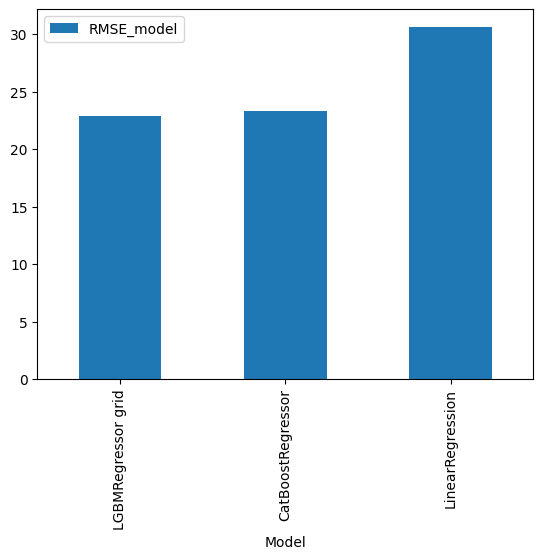

In [20]:
results['RMSE_model'].plot(kind='bar', legend=True)

In [24]:
del name_model, time_model, RMSE_model

Была проведена подготовка данных к дальнейшему обучению
Проведено обучение моделей:

* LinearRegression
* CatBoostRegressor
* LGBMRegressor по сетке

Все модели достаточно быстро обучались. Самое короткое время обучения и предсказания получено у Линейной регрессии, замыкает LGBMRegressor.

Лучшее значение `RMSE` получено у `LGBMRegressor` и составляет: 22.92, при времени обучения 10.98. Эти результаты полученны при `depth=6`.

## Тестирование

### CatBoostRegressor на тестовых данных

In [30]:
%%time
cat_model = CatBoostRegressor(eval_metric='RMSE', 
                          iterations=100,
                          depth=6,
                          verbose=False,
                          use_best_model=False,
                          random_seed=RND)

cat_model.fit(X_train, y_train)

cat_predictions = cat_model.predict(X_test)
rmse = mean_squared_error(y_test, cat_predictions, squared=False)

print('*'*30)
print('CatBoostRegressor RMSE:', rmse)
print('*'*30)

******************************
CatBoostRegressor RMSE: 45.544081452931025
******************************
CPU times: total: 1.02 s
Wall time: 163 ms


### LGBMRegressor на тестовых данных

In [34]:
%%time

lg_grid_model = LGBMRegressor(num_leaves= 51, 
                      learning_rate=0.01,
                      max_depth=21, 
                      n_estimators=50, 
                      random_state=RND)
lg_grid_model.fit(X_train, y_train)
rmse = mean_squared_error(y_test, lg_grid_model.predict(X_test), squared=False)

print('*'*30)
print('LGBMRegressor RMSE TEST:', rmse)
print('*'*30)

******************************
LGBMRegressor RMSE TEST: 68.31972435946513
******************************
CPU times: total: 344 ms
Wall time: 46.4 ms


### Анализ результатов тестирования

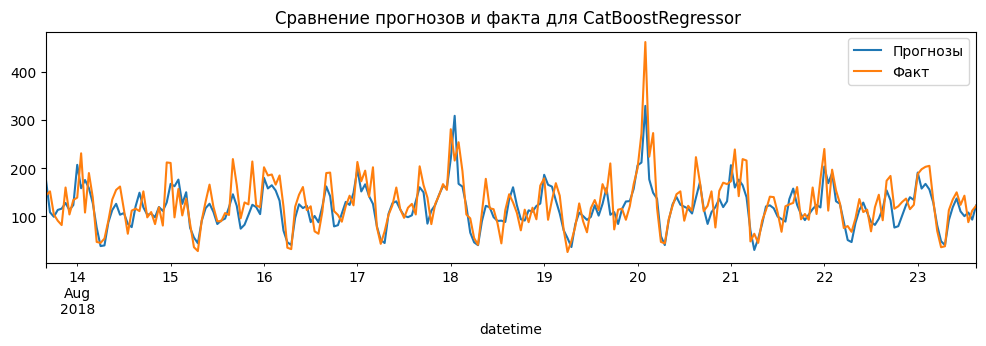

In [32]:
pd.DataFrame({'Прогнозы':cat_predictions,
             'Факт':y_test})[:240].plot(figsize=SIZE)
plt.title('Сравнение прогнозов и факта для CatBoostRegressor ')
plt.show()

### Вывод

В процессе работы был произведен анализ и подготовка данных к последующему обучению.<br>
Анализ данных выявил рост тренда со временем, что может свидетельствовать о увеличение спроса на услуги компании. Так же прослеживается суточная сезонность.

Для дальнейшей работы данные были преобразованы в стационарный ряд и произведена подготовка к дальнейшему обучению.

В процессе обучения рассматривались модели:

* LinearRegression
* CatBoostRegressor
* LGBMRegressor по сетке

Все модели достаточно быстро обучались. 

В дальнейшем все модели были проверены на тестовых данных.<br>
Наилучшие показатели получены у `CatBoostRegressor` при `iterations=100` и `depth=6`,:
* время предсказания составило 165 ms
* RMSE  45.54

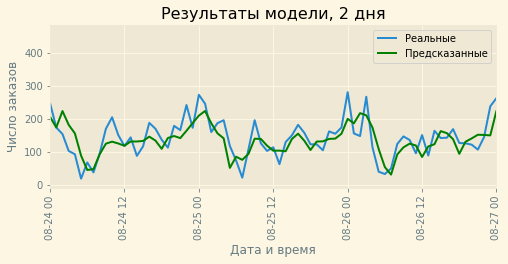